In [148]:
import time
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional
from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [ ]:
# def append_ones(matrix):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

# MNIST dataset

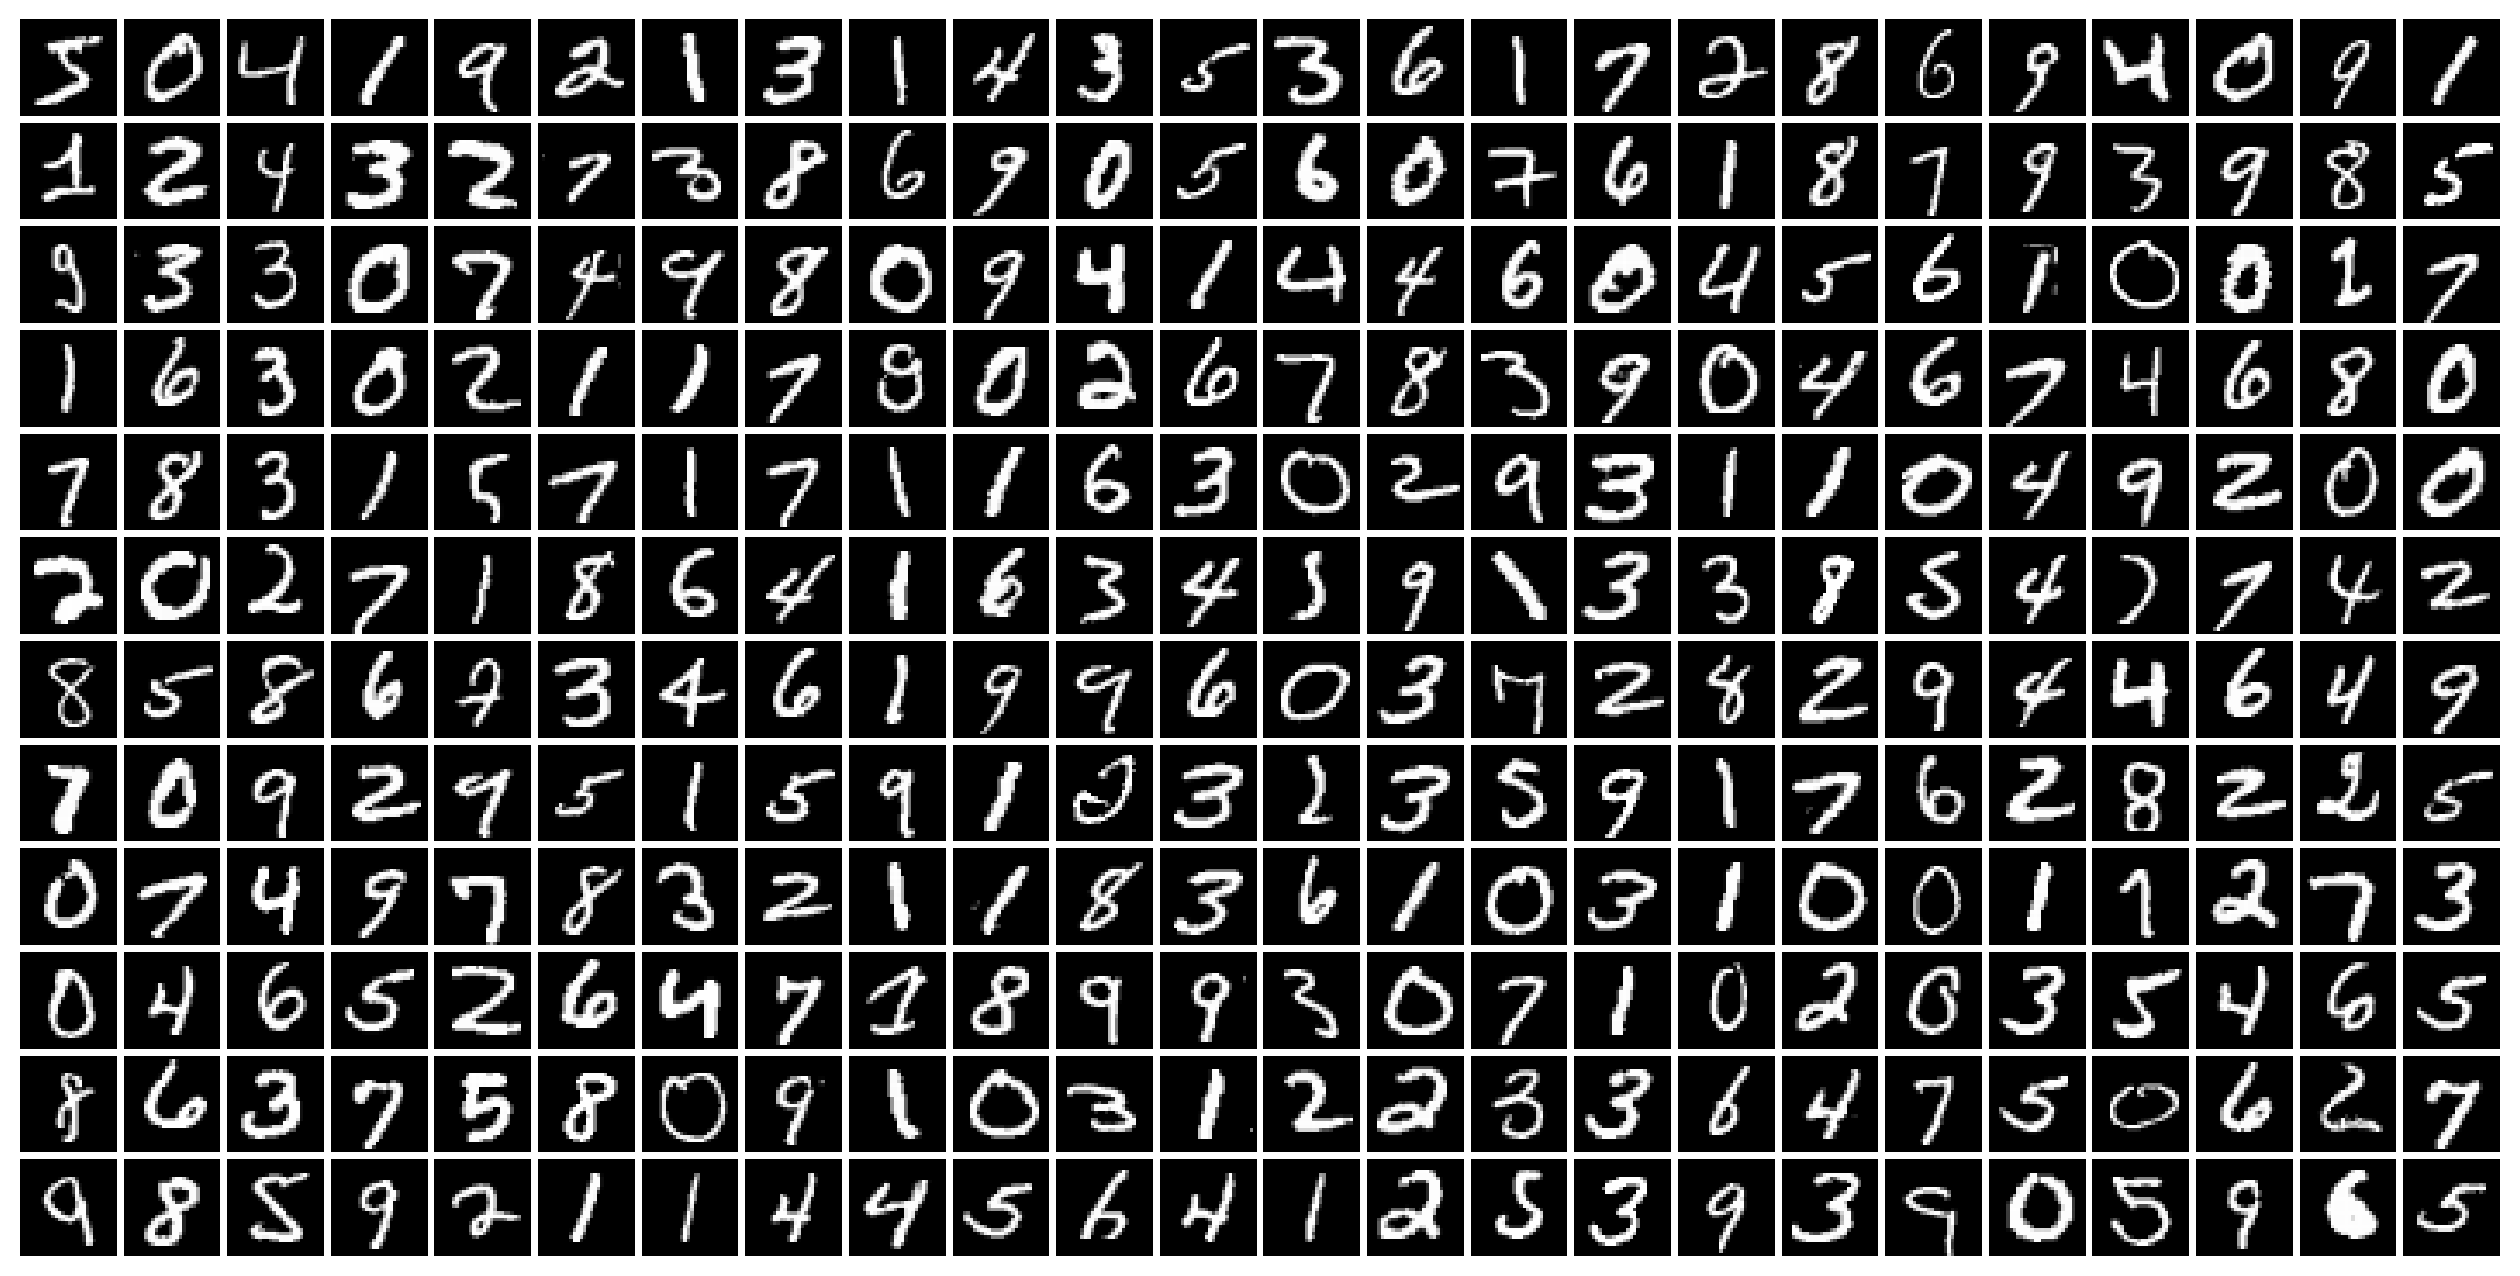

In [ ]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [151]:
def sigmoid(x: NDArray) -> NDArray:
    return 1.0 / (1.0 + np.exp(-x))


class RBM:
    def __init__(self, vsize: int, hsize: int, lr: float, pc_size: Optional[int] = None):
        self.vsize, self.hsize = vsize, hsize
        self.pc_size = pc_size
        self.lr = lr
        self.reset()

    def reset(self):
        # Xavier initialization
        scale = np.sqrt(6 / (self.vsize + self.hsize))
        self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)

        # Zero initialization
        self.b = zeros(self.vsize)
        self.c = zeros(self.hsize)

        # Persistent chain initialization
        if self.pc_size is not None:
            self.pc = zeros(self.pc_size, self.hsize)

    def probas_v(self, h: NDArray) -> NDArray:
        return sigmoid(self.b + h @ self.w.T)

    def probas_h(self, v: NDArray) -> NDArray:
        return sigmoid(self.c + v @ self.w)

    def sample(self, v: NDArray, steps: int) -> NDArray:
        batch_size = v.shape[0]
        # --- Gibbs sampling
        for k in range(steps):
            h = self.probas_h(v) > rand(batch_size, self.hsize)
            σ = self.probas_v(h)
            if k < steps - 1:
                v = σ > rand(batch_size, self.vsize)

        return σ

In [152]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    h = rbm.probas_h(v) > rand(batch_size, rbm.hsize)
    σ = rbm.probas_v(h)
    return 1 / batch_size * np.sum((v - σ) ** 2)

## Algorytm Contrastive Divergence

$\newcommand{\vect}[1]{\mathbf{#1}}$
W sieci RBM gradient funkcji kosztu względem wag wyznaczamy zgodnie ze wzorem:

$\frac{\delta}{\delta w_{ij}} -\log P(\vect{v}) = -\mathbf{E}[v_i h_j \vert \vect{v}] + \mathbf{E}[v_i h_j]$

#### Faza pozytywna - odpowiada za część $\mathbf{E}[v_i h_j \vert \vect{v}]$

Tą część gradientu wyznaczamy przez wyliczenie iloczynów $v_i h_j$ pomiędzy elementami wektora obserwacji ($v_i$) a prawdopodobieństwami aktywacji w warstwie ukrytej ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_P = \vect{v}^T\sigma(\vect{vW})$

#### Faza negatywna - odpowiada za część $\mathbf{E}[v_i h_j]$

Rozpoczynamy od prawdopodobieństw aktywacji neuronów w warstwie ukrytej, które zostały wyznaczone w fazie pozytywnej. Na ich podstawie losujemy próbkę aktywacji w warstwie ukrytej:

$\vect{h} = \sigma (\vect{vW}) > [rand_1, rand_2, \dots, rand_m]$

Następnie losujemy próbkę aktywacji w warstwie widocznej:

$\vect{v}_1 = \sigma (\vect{hW}^T) > [rand_1, rand_2, \dots, rand_n]$

Aby wyznaczyć *fantazję* sieci RBM, powyższe próbki losujemy (naprzemiennie) $k$ razy (gdzie $k$ to parametr algorytmu CD-*k*):

$\vect{h}_{k-1} = \sigma (\vect{v}_{k-1}\vect{W}) > [rand_1, rand_2, \dots, rand_m]$, 
$\vect{v}_k = \sigma (\vect{h}_{k-1}\vect{W}^T) > [rand_1, rand_2, \dots, rand_n]$

Część negatywną gradientu wyznaczamy poprzez wyliczenie iloczynów $v_{k_i} h_j$ pomiędzy elementami wektora *fantazji* RBM ($v_{k_i}$) a prawdopodobieństwami aktywacji w warstwie ukrytej wyliczonymi dla tejże *fantazji* ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_N = \vect{v}_k^T\sigma(\vect{v}_k\vect{W})$


#### Aktualizacja macierzy wag RBM

Uczymy stochastycznym spadkiem wzdłuż gradientu:

$\phi_{t+1} \leftarrow \phi_t - \epsilon \nabla$

co dla gradientu RBM daje:

$W_{t+1} \leftarrow W_t + \epsilon \nabla_P - \epsilon \nabla_N$

In [153]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch.copy()

    # Compute gradients
    # -----------------
    # Positive phase

    σ = rbm.probas_h(v)

    grad_w = -1 * (v.T @ σ) / batch_size
    grad_b = -1 * (v.sum(axis=0)) / batch_size
    grad_c = -1 * (σ.sum(axis=0)) / batch_size

    # Negative phase

    # --- Gibbs sampling
    h = σ > rand(batch_size, rbm.hsize)
    v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)
    for _ in range(k - 1):
        h = rbm.probas_h(v) > rand(batch_size, rbm.hsize)
        v = rbm.probas_v(h) > rand(batch_size, rbm.vsize)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v)

    grad_w += (v.T @ σ) / batch_size
    grad_b += (v.sum(axis=0)) / batch_size
    grad_c += (σ.sum(axis=0)) / batch_size

    # Update params
    # -------------
    rbm.w -= rbm.lr * grad_w
    rbm.b -= rbm.lr * grad_b
    rbm.c -= rbm.lr * grad_c

## Algorytm Persistent Contrastive Divergence

Algorytm Persistent Contrastive Divergence (PCD) różni się od algorytmu CD przebiegiem fazy negatywnej. Faza pozytywna przebiega w PCD tak samo jak w algorytmie CD.

W PCD faza negatywna rozpoczyna się od nie od przykładu uczącego, lecz od stanu *wirtualnych cząstek*, który został został zapamiętany w poprzedniej fazie negatywnej:

$\vect{h} = \vect{p}$,

gdzie $\vect{p}$ to macierz przechowująca stan *wirtualnych cząstek*. Po inicjalizacji negatywnego stanu ukrytego ($\vect{h}$) rozpoczynamy próbkowanie Gibbsa i wyznaczamy fantazję sieci ($\vect{v}_k$). Następnie zapamiętujemy nowy stan wirtualnych cząstek:

$\vect{p} = \sigma (\vect{v}_k\vect{W}) > [rand_1, rand_2, \dots, rand_m]$.

Na koniec aktualizujemy wagi RBM. Aktualizacja wag przebiega tak samo jak w algorytmie CD.

In [154]:
def pcd(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch.copy()

    # Compute gradients
    # -----------------

    # Positive phase
    σ = rbm.probas_h(v)

    grad_w = -1 / batch_size * (v.T @ σ)
    grad_b = -1 / batch_size * (v.sum(axis=0))
    grad_c = -1 / batch_size * (σ.sum(axis=0))

    # Negative phase

    # --- Gibbs sampling
    h = rbm.pc  # Start from persistent chain
    v = rbm.probas_v(h) > rand(rbm.pc_size, rbm.vsize)
    for _ in range(k - 1):
        h = rbm.probas_h(v) > rand(rbm.pc_size, rbm.hsize)
        v = rbm.probas_v(h) > rand(rbm.pc_size, rbm.vsize)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v)

    grad_w += 1 / rbm.pc_size * (v.T @ σ)
    grad_b += 1 / rbm.pc_size * (v.sum(axis=0))
    grad_c += 1 / rbm.pc_size * (σ.sum(axis=0))

    # --- Update persistent chain
    rbm.pc = σ > rand(rbm.pc_size, rbm.hsize)

    # Update params
    # -------------
    rbm.w -= rbm.lr * grad_w
    rbm.b -= rbm.lr * grad_b
    rbm.c -= rbm.lr * grad_c

# RBM Training

In [155]:
def sample_rbm(rbm, minibatch, steps):
    observations_count = minibatch.shape[0]

    # BUG: If you are keeping all the parameters in a single matrix `W`, you should COPY the
    # minibatch as the later assignments (that use slicing) MODIFY the input minibatch.
    visible = minibatch  # .copy()
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    for cd_i in range(steps):
        hidden[:, :-1] = sigmoid(visible @ rbm.W[:, :-1])
        hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)

        visible[:, :-1] = sigmoid(hidden @ np.transpose(rbm.W[:-1, :]))
        if cd_i < (steps - 1):
            visible[:, :-1] = (visible[:, :-1] > rand(observations_count, rbm.visible_size)).astype(np.float32)

    return visible

In [156]:
def draw_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    filters = np.clip(filters, -1, 1)
    tiles(filters)


def draw_samples(rbm: RBM, initial_batch: NDArray, steps=200):
    samples = rbm.sample(initial_batch, steps)
    samples = samples.reshape(-1, 24, 28, 28)
    tiles(samples)

In [157]:
def train_epoch(rbm, dataset, batch_size, training_algorithm=cdk):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        training_algorithm(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

def run_training(rbm, dataset, monitoring_set, batch_size, epochs_count, training_algorithm=cdk):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch),  end="\t")

        start_time = time.perf_counter()
        train_epoch(rbm, dataset, batch_size, training_algorithm)

        elapsed = time.perf_counter() - start_time
        error = reconstuction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")

In [158]:
DATASET_SIZE = 20_000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = mnist_train[:DATASET_SIZE]
dataset = dataset.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

## CDK Training

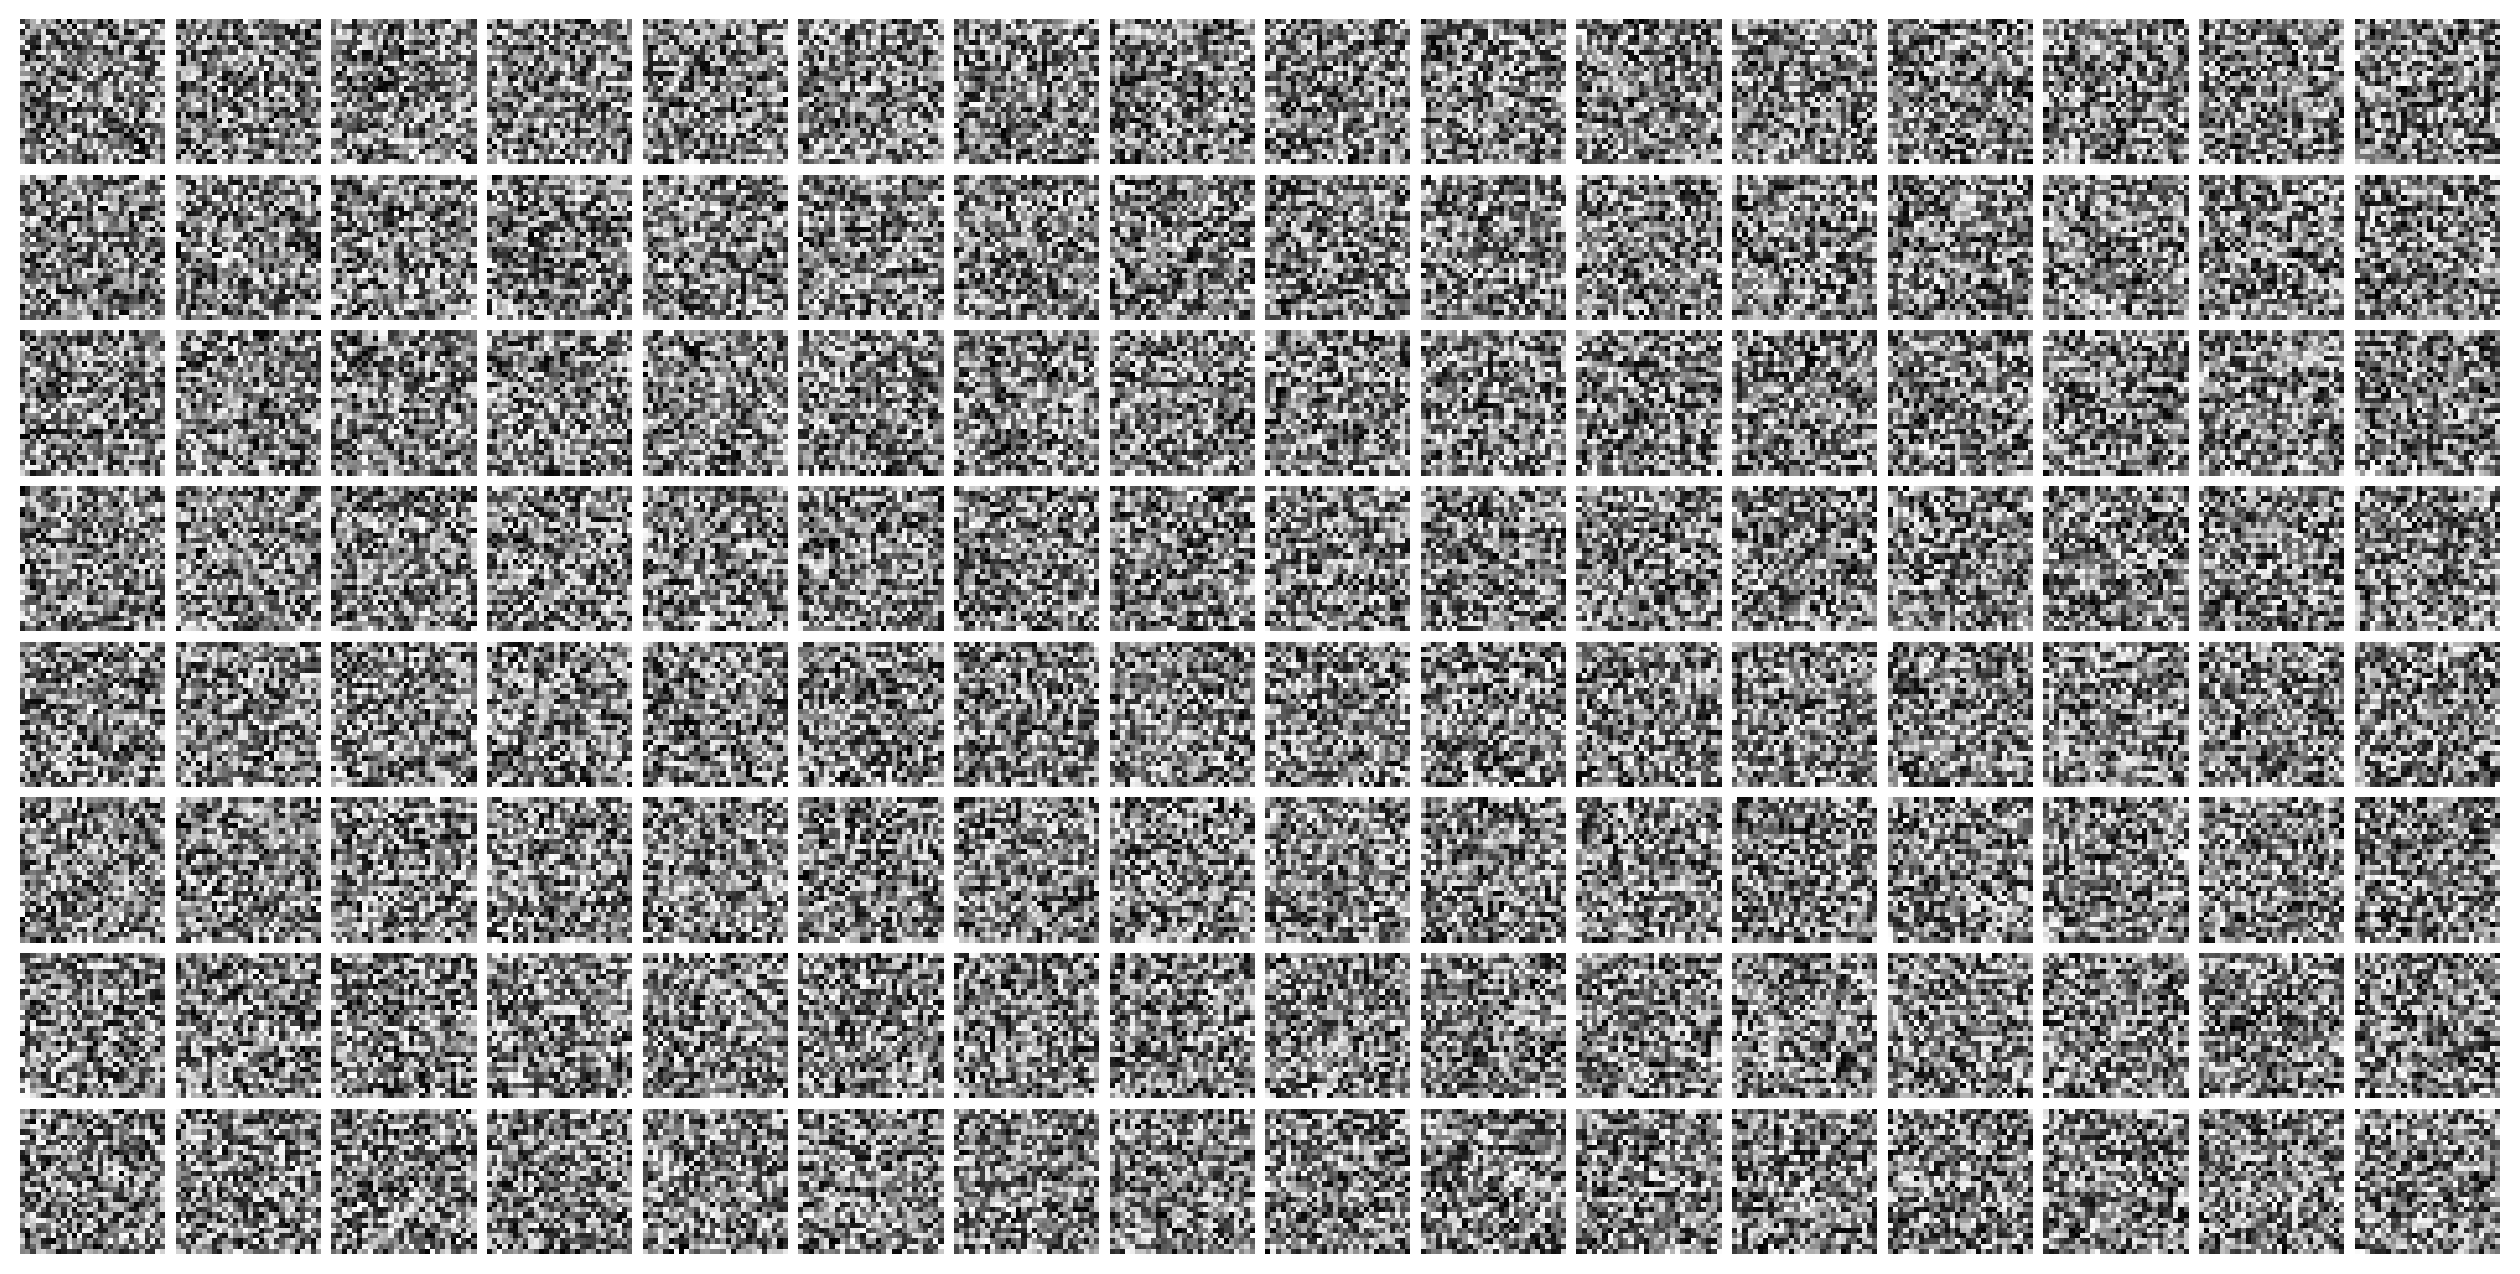

Epoch 0:	#####################################################	elapsed: 0.52s, reconstruction error: 28.66
Epoch 1:	#####################################################	elapsed: 0.45s, reconstruction error: 23.73
Epoch 2:	#####################################################	elapsed: 0.69s, reconstruction error: 21.38
Epoch 3:	#####################################################	elapsed: 0.47s, reconstruction error: 19.90
Epoch 4:	#####################################################	elapsed: 0.34s, reconstruction error: 18.78
Epoch 5:	#####################################################	elapsed: 0.25s, reconstruction error: 18.01
Epoch 6:	#####################################################	elapsed: 0.43s, reconstruction error: 17.28
Epoch 7:	#####################################################	elapsed: 0.51s, reconstruction error: 16.80
Epoch 8:	#####################################################	elapsed: 0.58s, reconstruction error: 16.20
Epoch 9:	############################

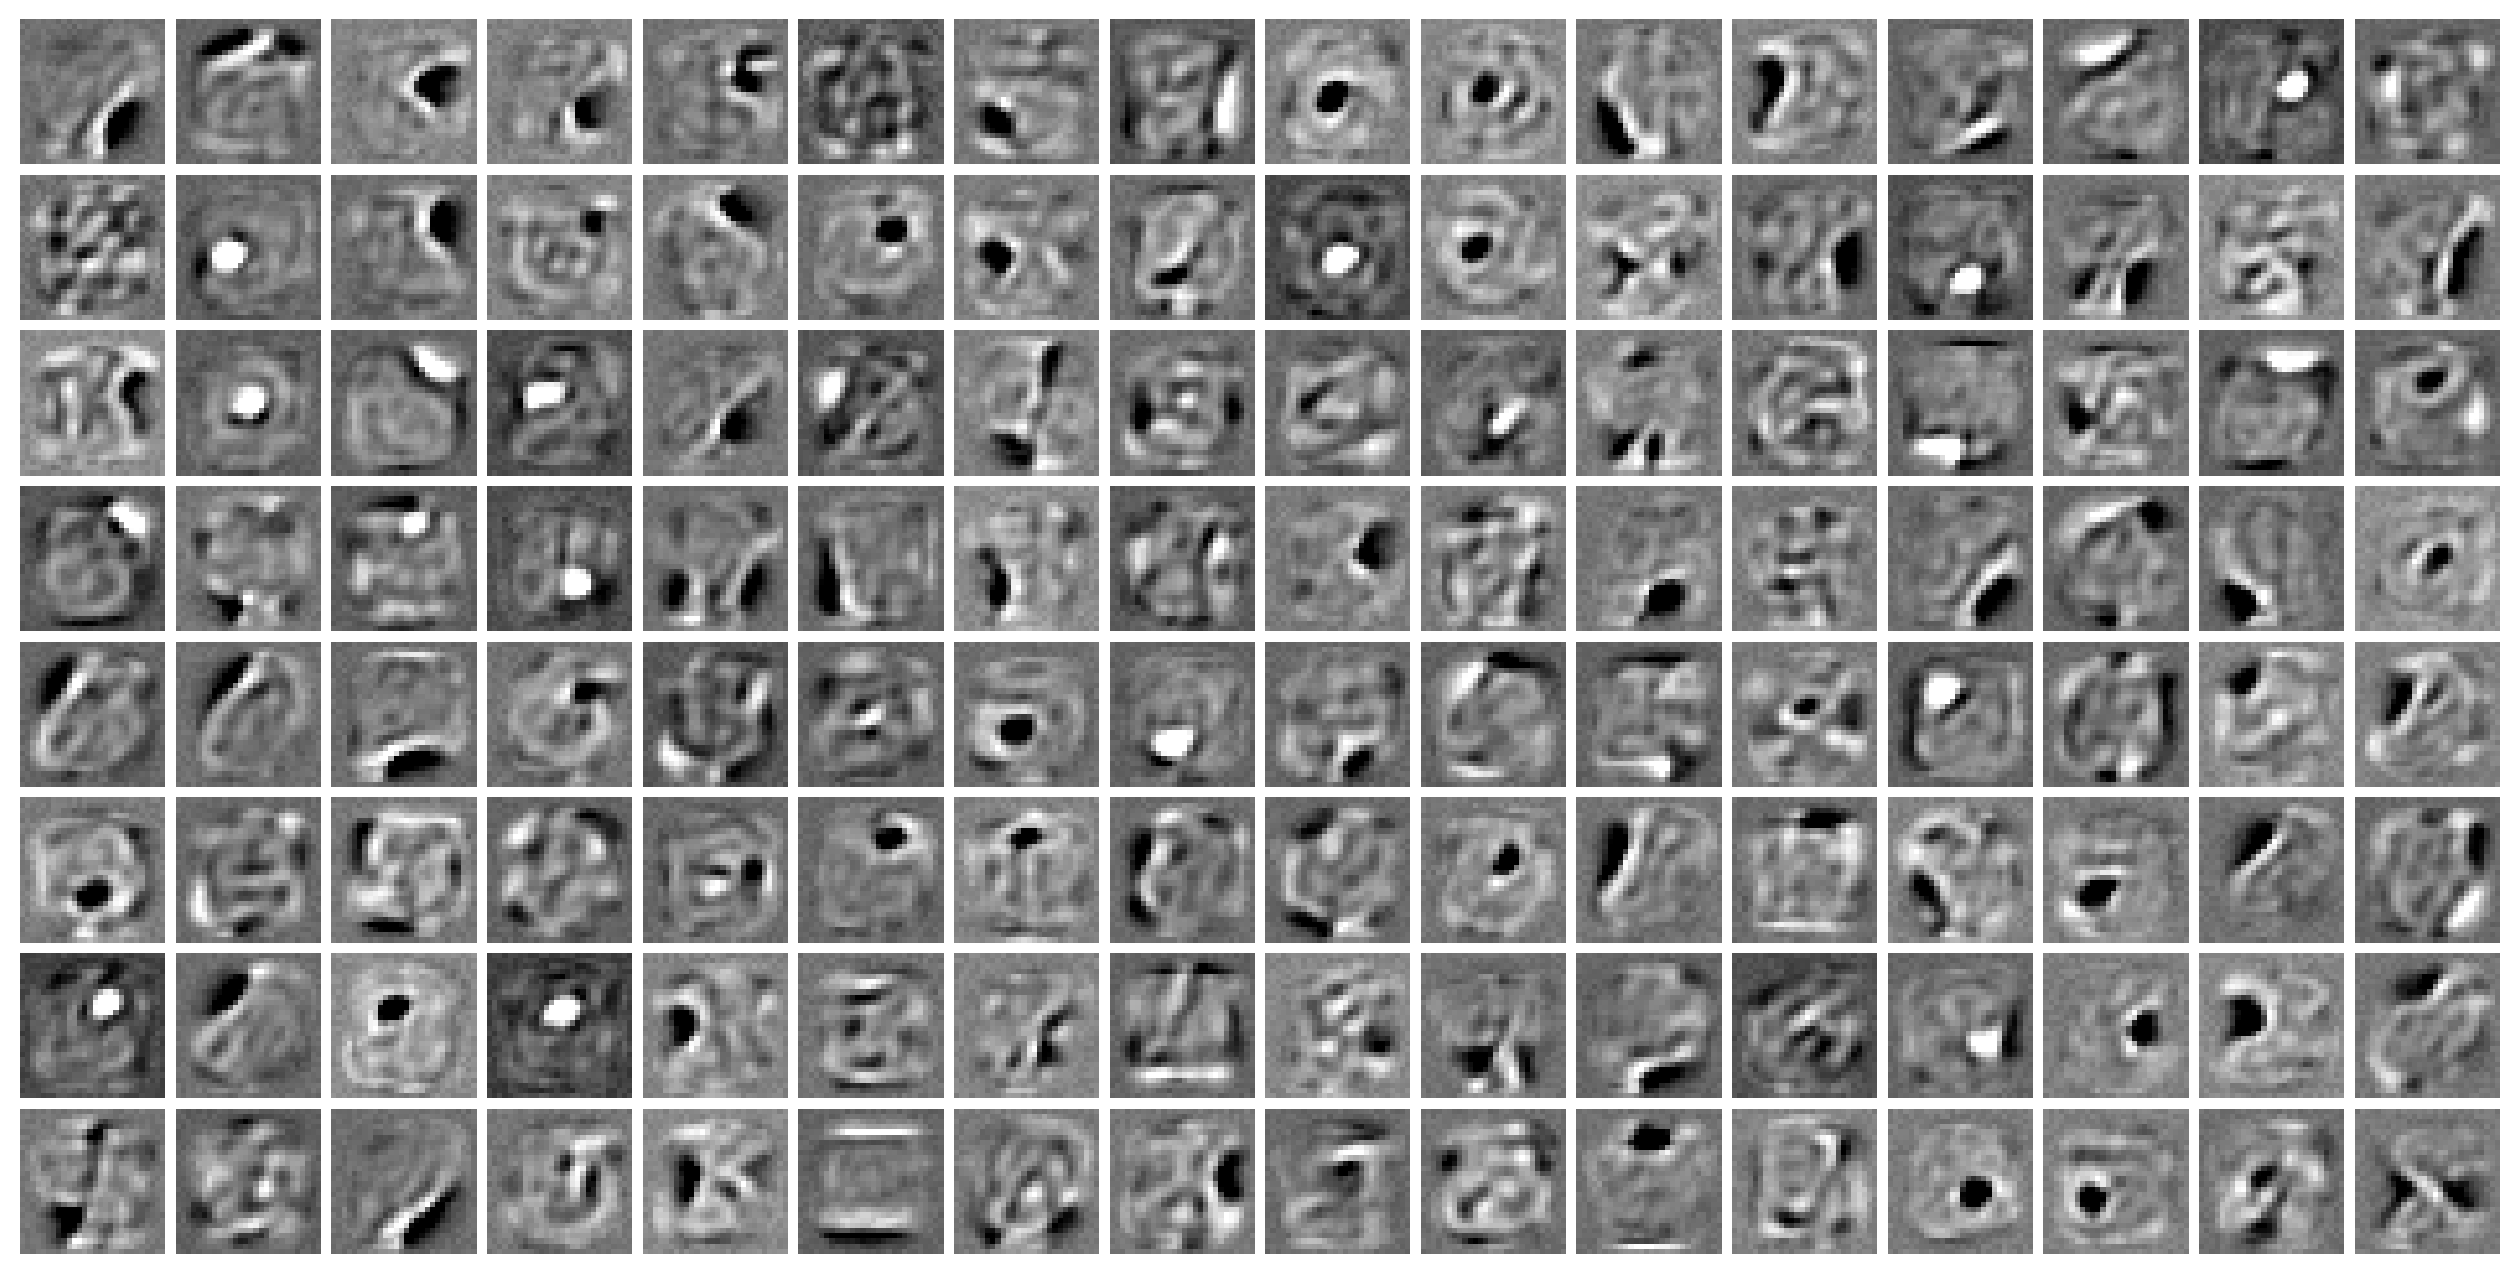

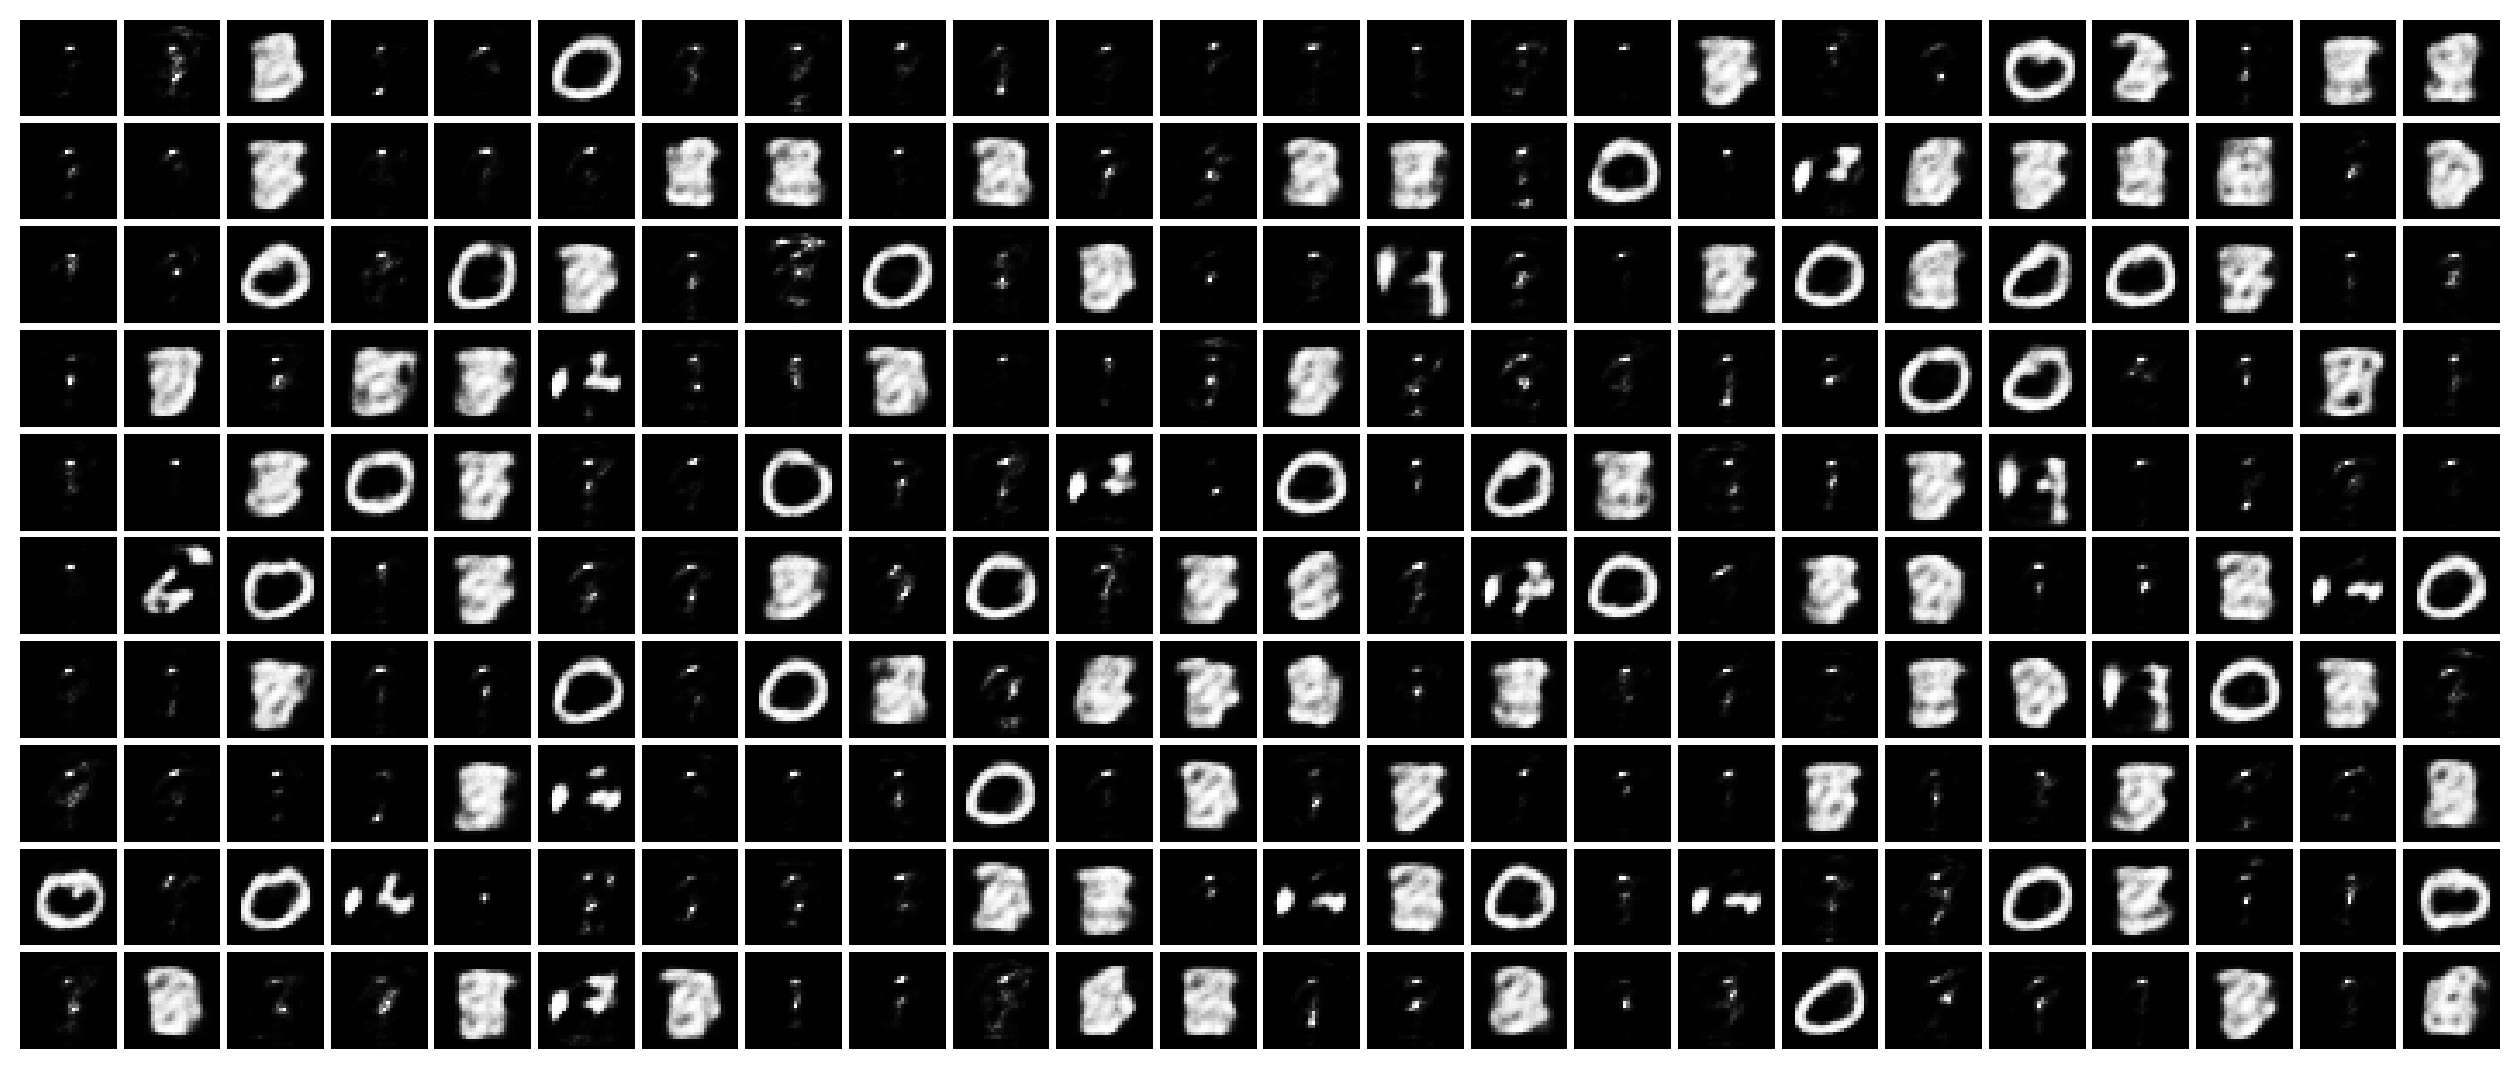

In [159]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

CDK_LEARNING_RATE = 0.1

rbm = RBM(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, CDK_LEARNING_RATE)
draw_filters(rbm)

run_training(rbm, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT, cdk)

draw_filters(rbm)
draw_samples(rbm, monitoring_set[: 10 * 24], steps=1_000)

## PCD Training

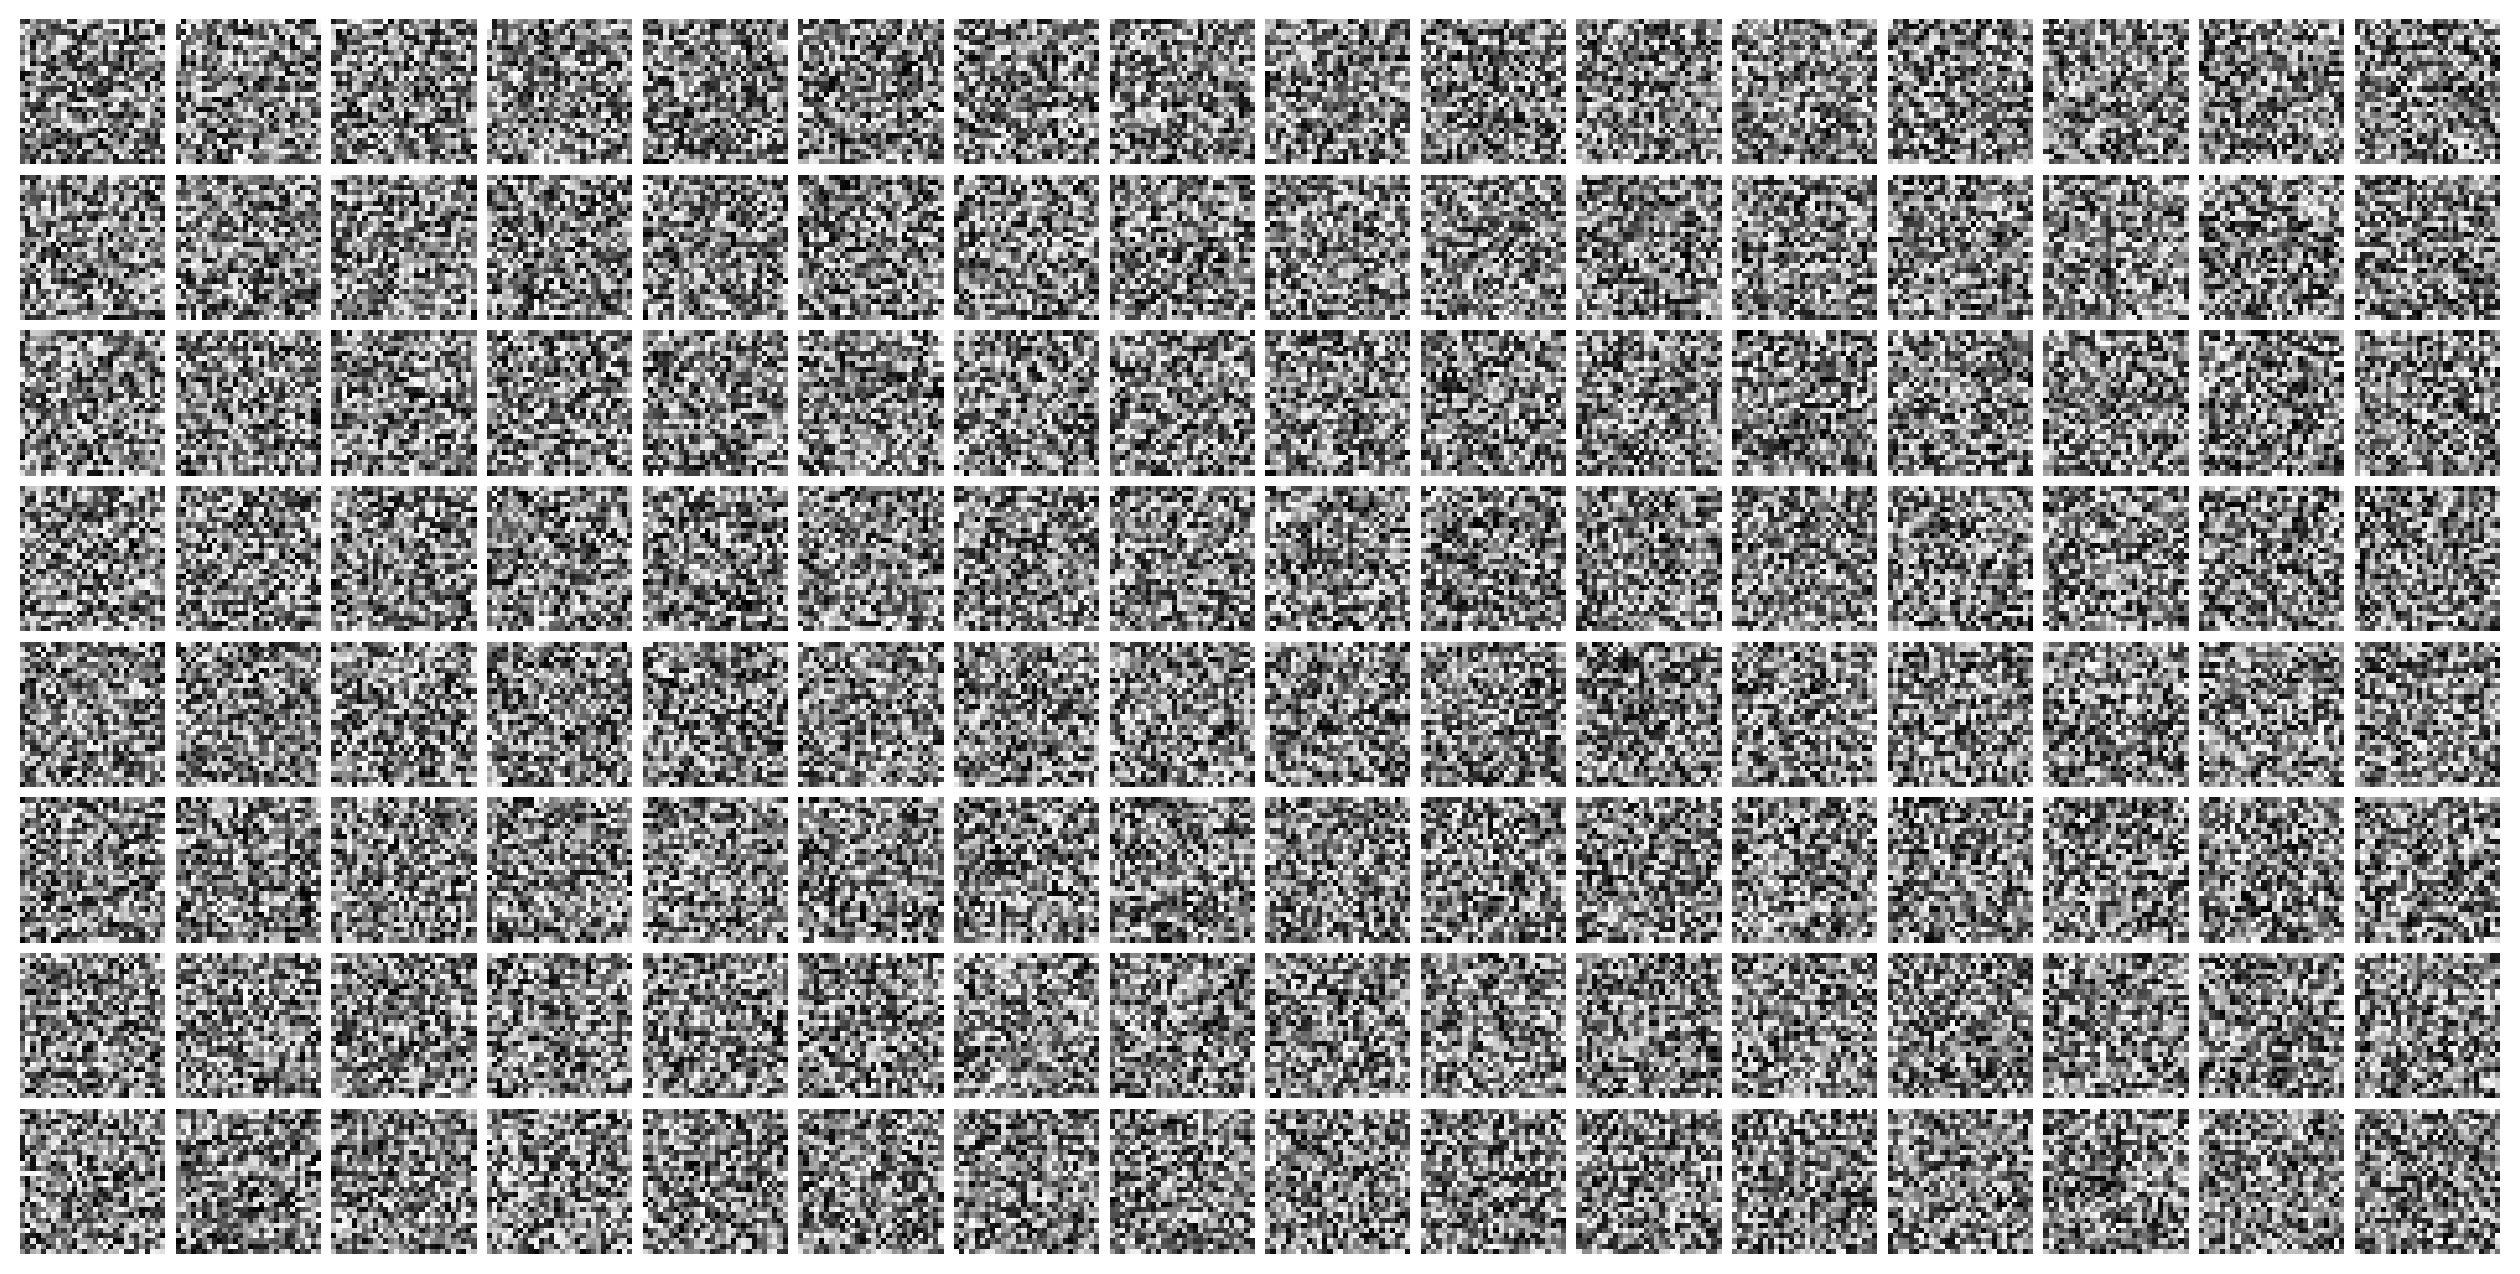

Epoch 0:	#####################################################	elapsed: 0.46s, reconstruction error: 72.13
Epoch 1:	#####################################################	elapsed: 0.49s, reconstruction error: 52.07
Epoch 2:	#####################################################	elapsed: 0.38s, reconstruction error: 41.41
Epoch 3:	#####################################################	elapsed: 0.34s, reconstruction error: 36.25
Epoch 4:	#####################################################	elapsed: 0.38s, reconstruction error: 34.01
Epoch 5:	#####################################################	elapsed: 0.36s, reconstruction error: 32.55
Epoch 6:	#####################################################	elapsed: 0.34s, reconstruction error: 31.24
Epoch 7:	#####################################################	elapsed: 0.38s, reconstruction error: 30.34
Epoch 8:	#####################################################	elapsed: 0.43s, reconstruction error: 29.26
Epoch 9:	############################

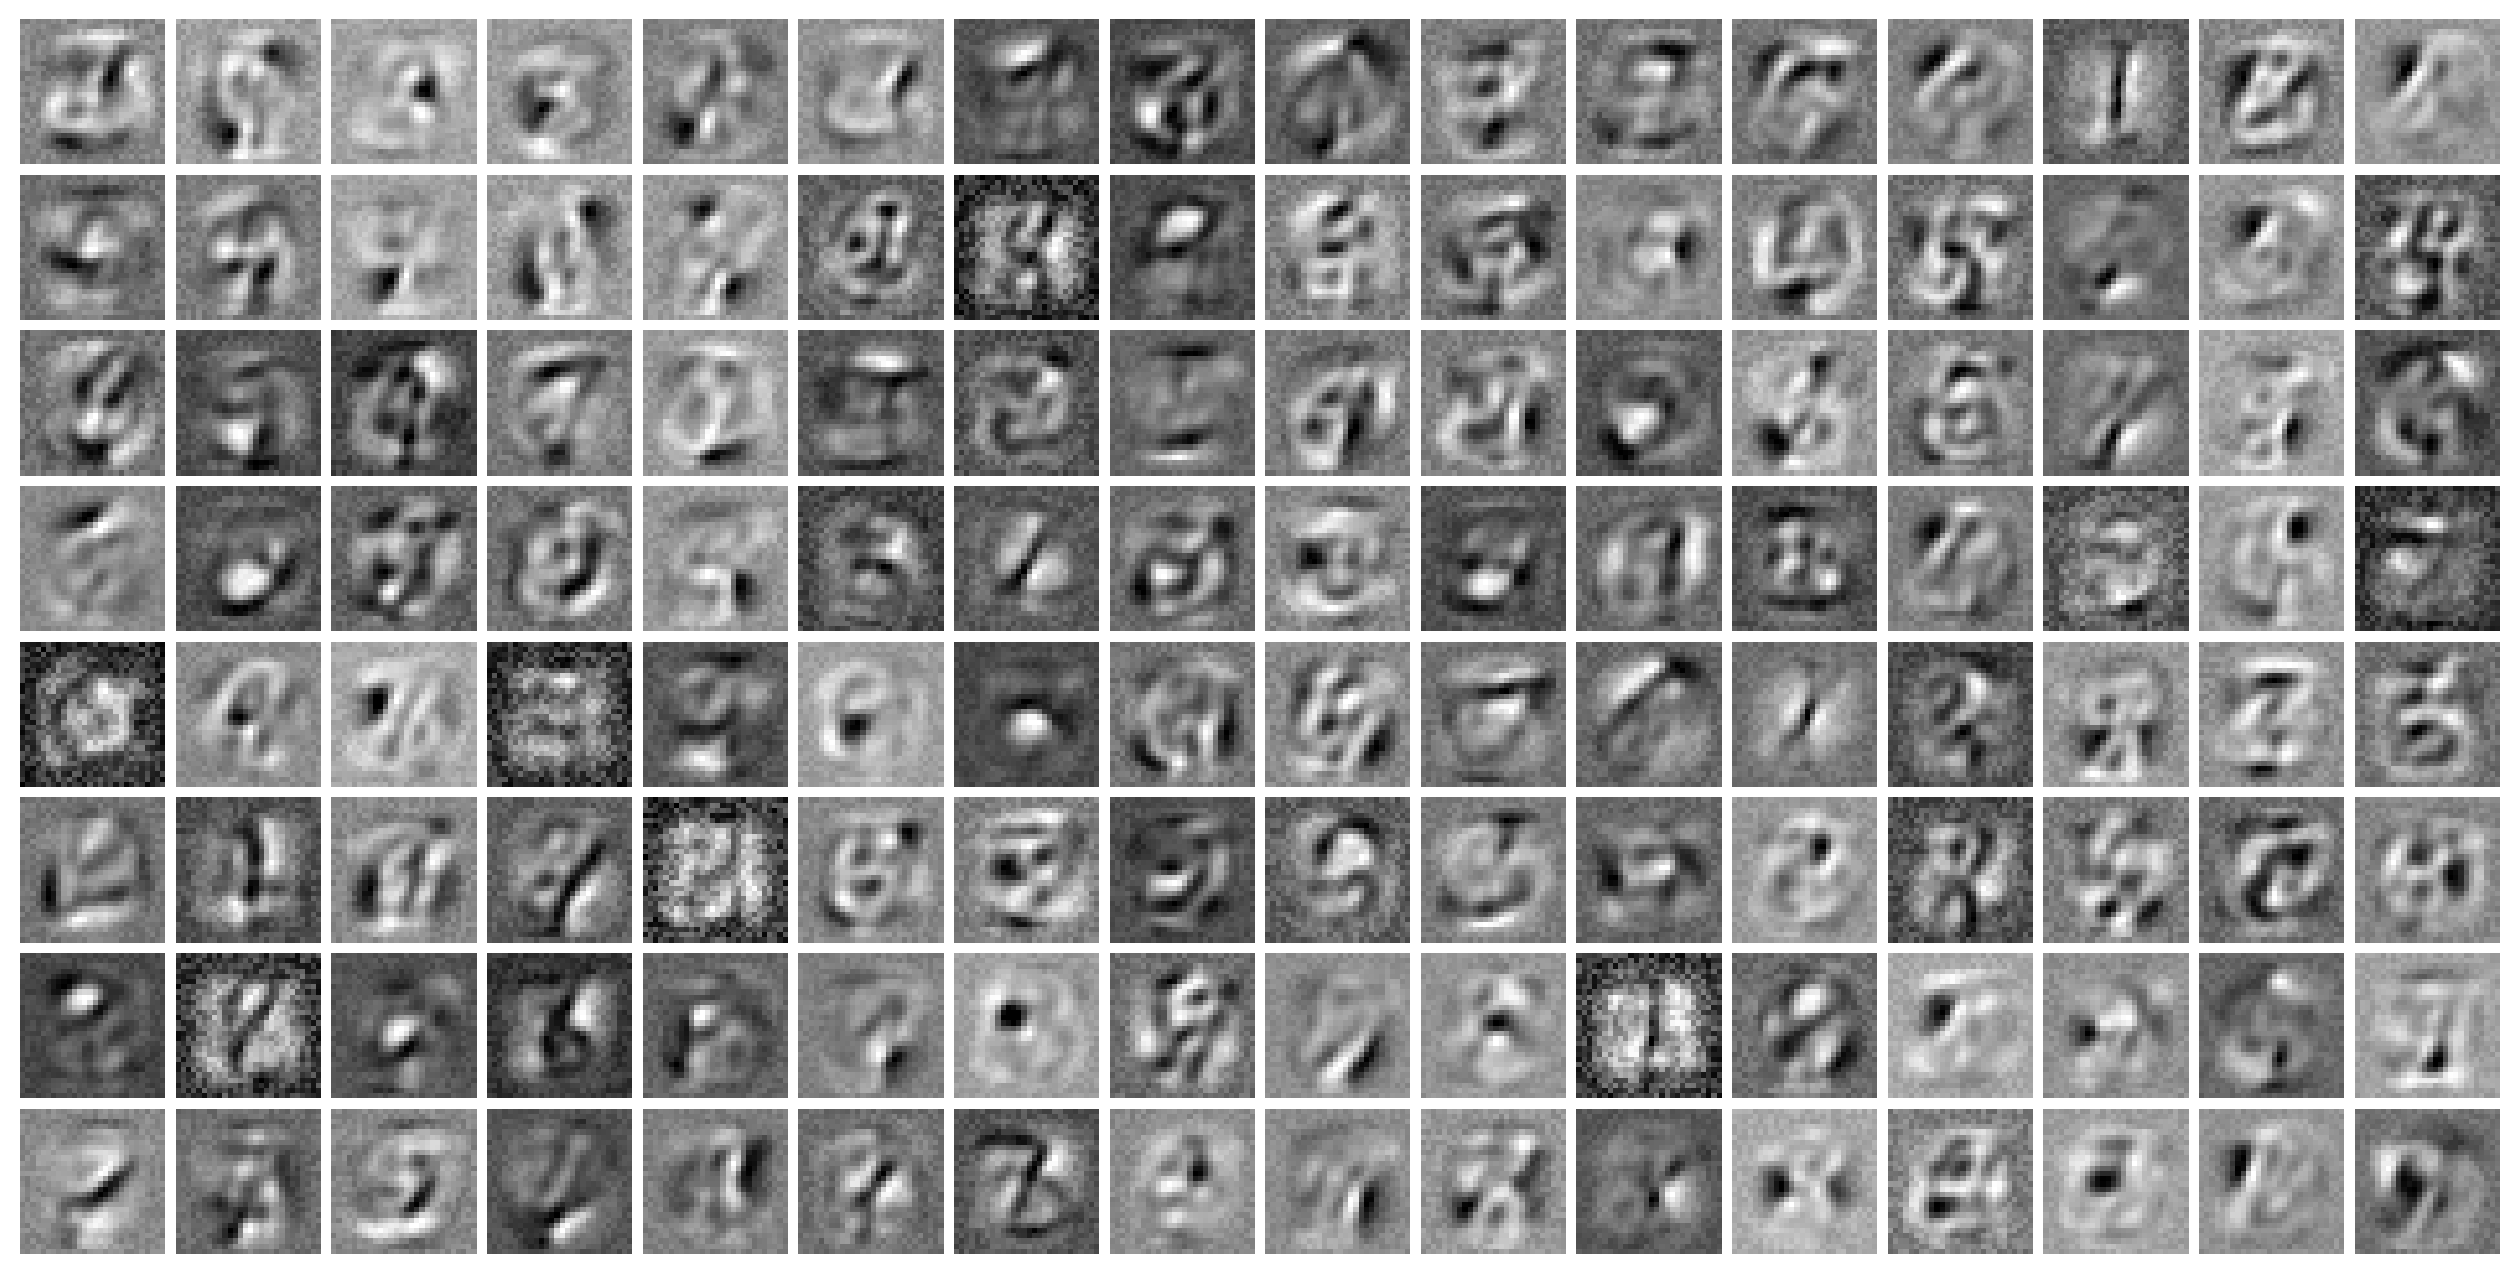

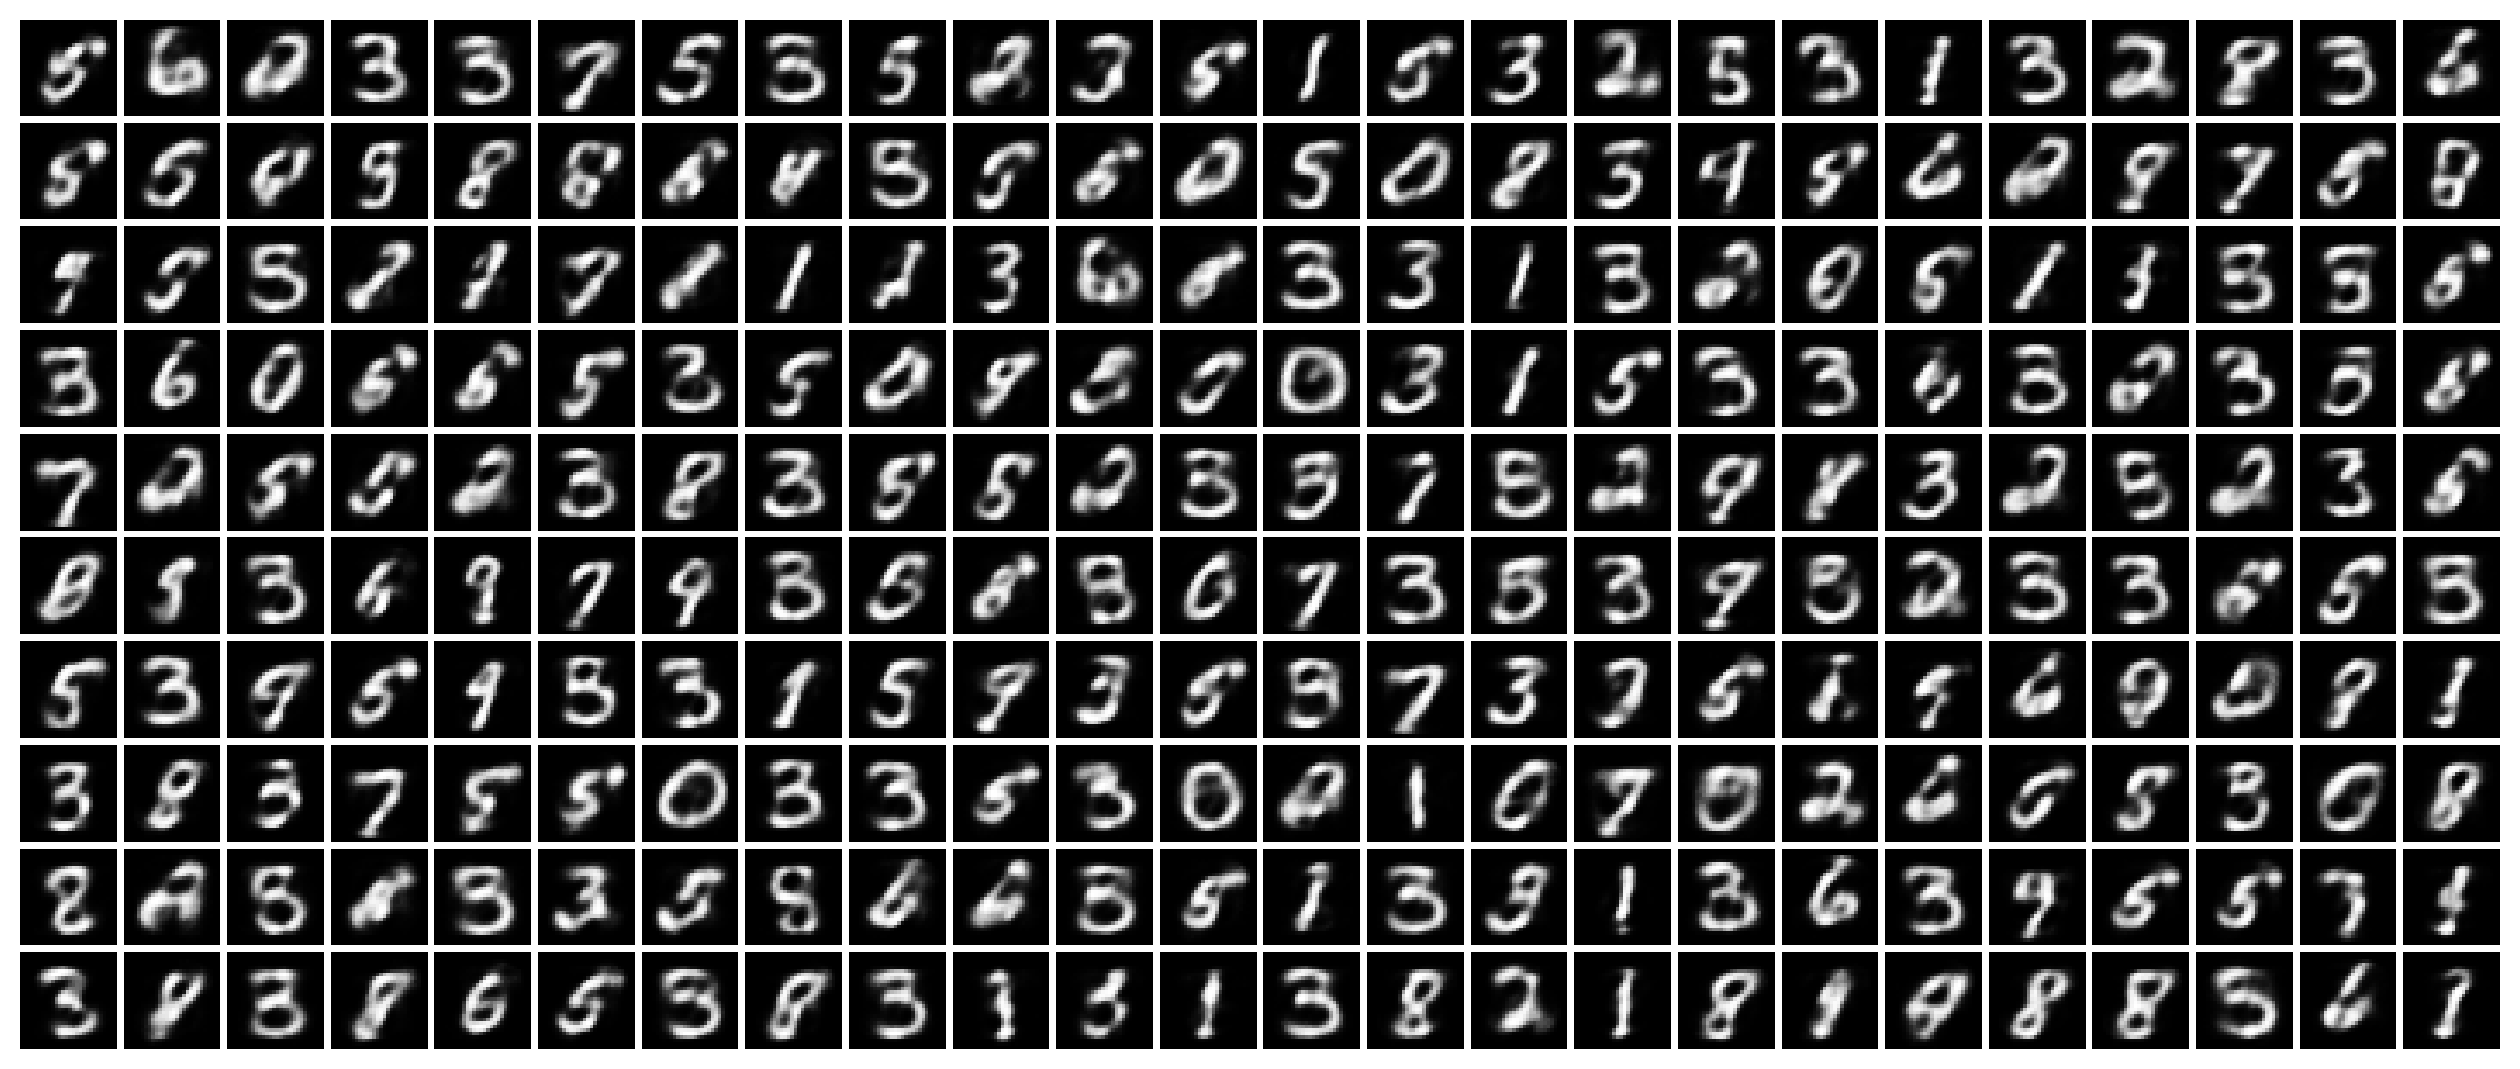

In [160]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

PCD_PARTICLES_COUNT = 128
PCD_LEARNING_RATE = 0.01

rbm_pcd = RBM(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, PCD_LEARNING_RATE, PCD_PARTICLES_COUNT)
draw_filters(rbm_pcd)

run_training(rbm_pcd, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT, pcd)

draw_filters(rbm_pcd)
draw_samples(rbm_pcd, monitoring_set[: 10 * 24], steps=1_000)